In [27]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os, random
import sys
sys.path.append('../')
import astropy

from data import KMTData
from data import OGLEData

random.seed(42)

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16


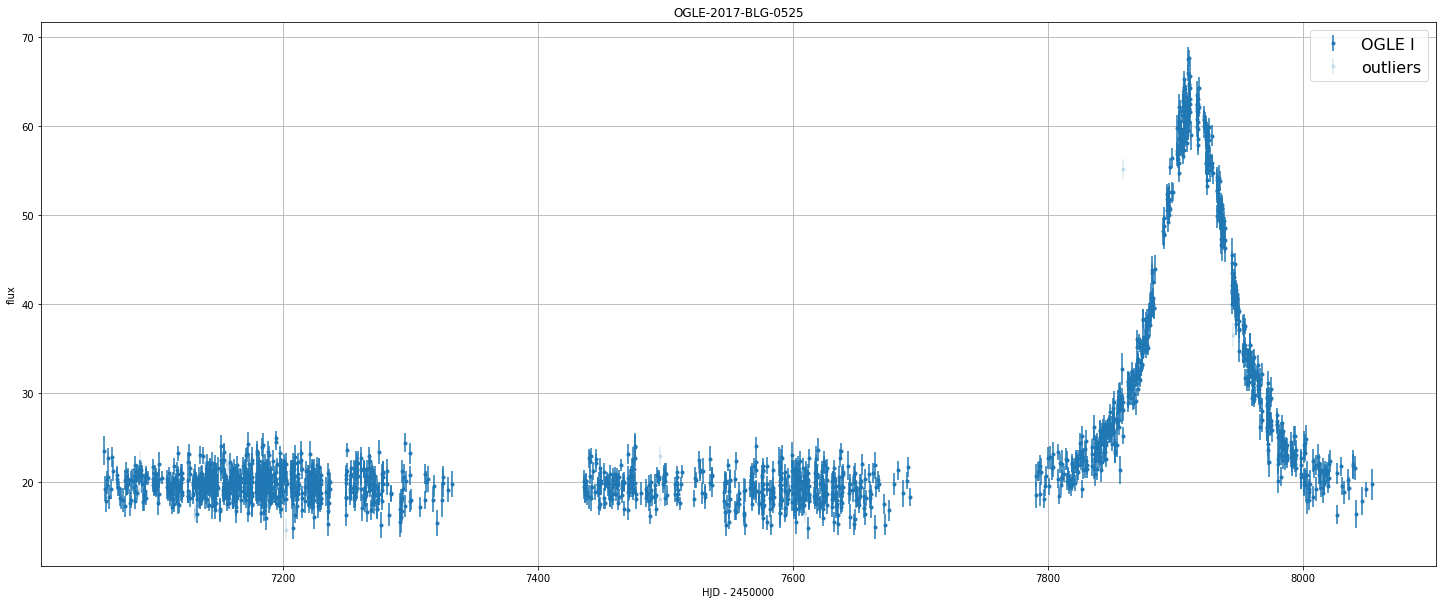

In [4]:
event = OGLEData('/home/star/fb90/data/OGLE_ews/2017/blg-0525')
fig, ax = plt.subplots(figsize=(25, 10))
event.remove_worst_outliers(window_size=11, mad_cutoff=7)
event.plot(ax)

# Query JPL horizons and get Eath's orbital elements for each $t_i$


In [5]:
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u

start = Time(event.tables[0]['HJD'][0], format='jd')
stop = Time(event.tables[0]['HJD'][-1], format='jd')

epochs={'start':start.iso[:10], 'stop':stop.iso[:10], 'step':'6h'}
obj = Horizons(id='399', id_type='id', epochs=epochs)

In [6]:
elements = obj.elements()
elements

targetname,datetime_jd,datetime_str,e,q,incl,Omega,w,Tp_jd,n,M,nu,a,Q,P
---,d,---,---,AU,deg,deg,deg,d,deg / d,deg,deg,AU,AU,d
str11,float64,str30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Earth (399),2457059.5,A.D. 2015-Feb-06 00:00:00.0000,0.016147432121,0.98307241715,0.00110079000079,236.758073225,224.413210897,2457024.62189,0.986782627227,34.4171132974,35.4805970272,0.999207045085,1.01534167302,364.821988214
Earth (399),2457059.75,A.D. 2015-Feb-06 06:00:00.0000,0.0161729737979,0.983064368582,0.00111173642612,239.57215165,221.577261882,2457024.60107,0.986756318928,34.683433075,35.7557832908,0.999224805175,1.01538524177,364.831714877
Earth (399),2457060.0,A.D. 2015-Feb-06 12:00:00.0000,0.0161997945326,0.983056870844,0.0011237940887,242.088006338,219.045007888,2457024.58563,0.986727256806,34.9443230434,36.0254796388,0.99924442522,1.0154319796,364.842460281
Earth (399),2457060.25,A.D. 2015-Feb-06 18:00:00.0000,0.0162278265688,0.983049952662,0.00113627998843,244.307897224,216.814235136,2457024.57563,0.986695499612,35.1997407225,36.289639978,0.999265865829,1.015481779,364.854202884
Earth (399),2457060.5,A.D. 2015-Feb-07 00:00:00.0000,0.0162570011493,0.983043641686,0.00114858835185,246.237638906,214.879162875,2457024.57109,0.98666110925,35.4496558615,36.5482305122,0.999289085498,1.01553452931,364.866919984
Earth (399),2457060.75,A.D. 2015-Feb-07 06:00:00.0000,0.0162872486222,0.98303796446,0.00116019409918,247.88490719,213.232137335,2457024.57204,0.986624150648,35.6940499616,36.8012292618,0.999314040693,1.01559011693,364.880587774
Earth (399),2457061.0,A.D. 2015-Feb-07 12:00:00.0000,0.0163184985241,0.983032946411,0.00117065299173,249.257892299,211.864978987,2457024.57848,0.986584691658,35.9329157949,37.0486255774,0.99934068592,1.01564842543,364.895181371
Earth (399),2457061.25,A.D. 2015-Feb-07 18:00:00.0000,0.0163506796416,0.983028611838,0.00117959993007,250.364280916,210.770000989,2457024.59041,0.986542802978,36.1662569314,37.2904196616,0.999368973772,1.01570933571,364.910674847


# Calculate $\gamma_n(t)$ and $\gamma_w(t)$

In [8]:
coordinates_ecliptic = event.coordinates.transform_to('geocentrictrueecliptic')
lambda_0 = coordinates_ecliptic.lon.value*(np.pi/180)
beta_0  = coordinates_ecliptic.lat.value*(np.pi/180)

t = np.array(elements['datetime_jd']) # JD
e = np.array(elements['e'])
tp = np.array(elements['Tp_jd']) # JD
n = (2*np.pi/365.25) # mean motion
Phi_gamma = (77.86)*np.pi/180 # true anomaly at vernal eq. on J2000
r_sun = 1 - e*np.cos(n*(t - tp)) # to 1st order in e
lambda_sun = n*(t - tp) - Phi_gamma + 2*e*np.sin(n*(t - tp)) # to 1st order in e

gamma_w = r_sun*np.sin((lambda_sun - lambda_0))
gamma_n = r_sun*np.sin(beta_0)*np.cos(lambda_sun - lambda_0)

gamma_w_dot = n*((1 + e*np.cos(n*(t - tp)))*np.cos(lambda_sun - lambda_0)+\
    e*np.sin(n*(t - tp))*np.sin(lambda_sun - lambda_0))
gamma_n_dot = -n*np.sin(beta_0)*((1 + e*np.cos(n*(t - tp)))*np.sin(lambda_sun - lambda_0) -\
    e*np.sin(n*(t - tp))*np.cos(lambda_sun - lambda_0))

gamma_w_ddot = -n**2*(1 + 2*e*np.cos(n*(t - tp)))*np.sin(lambda_sun - lambda_0)
gamma_n_ddot = -n**2*np.sin(beta_0)*(1 + 2*e*np.cos(n*(t - tp)))*np.cos(lambda_sun - lambda_0)

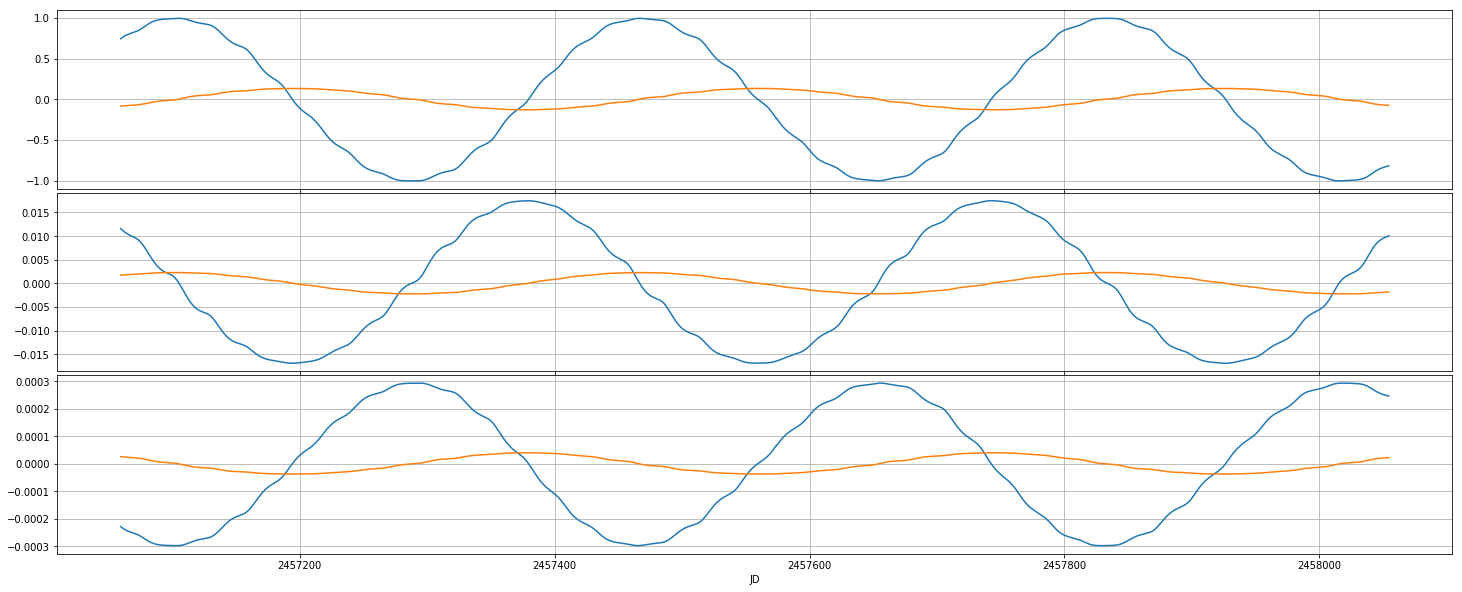

In [9]:
fig, ax = plt.subplots(3,1, figsize=(25, 10), sharex=True)
fig.subplots_adjust(hspace=0.02)
ax[0].plot(t, gamma_w, 'C0', label='gamma_w')
ax[0].plot(t, gamma_n, 'C1', label='gamma_n')
ax[1].plot(t, gamma_w_dot, 'C0', label='gamma_w_dot')
ax[1].plot(t, gamma_n_dot, 'C1', label='gamma_n_dot')
ax[2].plot(t, gamma_w_ddot, 'C0', label='gamma_w_ddot')
ax[2].plot(t, gamma_n_ddot, 'C1', label='gamma_n_ddot')
ax[2].set_xlabel('JD')
for a in ax.ravel():
    a.grid()

# Testing different parametrizations

Text(0, 0.5, '$u_n$')

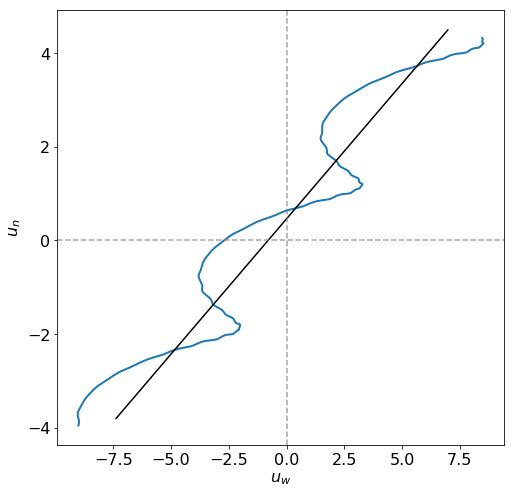

In [74]:
def compute_u(t_, u0, t0, omegaE, psi, piE):
    gamma_w_interp = np.interp(t_, t, gamma_w)
    gamma_n_interp = np.interp(t_, t, gamma_n)
    
    u_w = -u0*np.sin(psi) - omegaE*(t_ - t0)*np.cos(psi) + piE*gamma_w_interp
    u_n = u0*np.cos(psi) - omegaE*(t_ - t0)*np.sin(psi) + piE*gamma_n_interp

    return u_w, u_n
    
t_ = np.linspace(t[0], t[-1], 1000)

t0 = 0.5*(t[-1] + t[0])
tE = 60.

u_w, u_n = compute_u(t_, 0.4, t0, 1/tE, 30*(np.pi/180), 2)
u_w_linear, u_n_linear = compute_u(t_, 0.4, t0, 1/tE, 30*(np.pi/180), 0.)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(u_w, u_n, color='C0', lw=2.)
ax.plot(u_w_linear, u_n_linear, color='black', lw=1.5)
ax.axvline(0., color='grey', linestyle='dashed', alpha=0.7)
ax.axhline(0., color='grey', linestyle='dashed', alpha=0.7)
# ax.grid()
ax.set_xlabel(r'$u_w$')
ax.set_ylabel('$u_n$')
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)

Text(0, 0.5, '$u$')

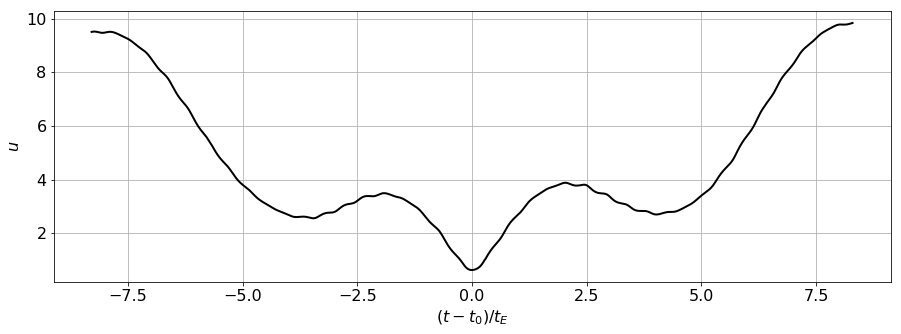

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot((t_ - t0)/tE, np.sqrt(u_w**2 + u_n**2), color='black', lw=2.)
ax.grid()
ax.set_xlabel(r'$(t - t_0)/t_E$')
ax.set_ylabel(r'$u$')

### Alternative parametrization

In [78]:
def compute_u_alternative(t_, u0p, t0p, vop, ap, av):
    gamma_w_ddot_t0p = np.interp(t0p, t, gamma_w_ddot)
    gamma_n_ddot_t0p = np.interp(t0p, t, gamma_n_ddot)
    gamma_w_dot_t0p = np.interp(t0p, t, gamma_w_dot)
    gamma_n_dot_t0p = np.interp(t0p, t, gamma_n_dot)
    gamma_w_t0p = np.interp(t0p, t, gamma_w)
    gamma_n_t0p = np.interp(t0p, t, gamma_n)

    piE = np.sqrt((ap**2 + av**2)/(gamma_w_ddot_t0p**2 + gamma_n_ddot_t0p**2))
    sinphi = piE*(gamma_w_ddot_t0p*av - gamma_n_ddot_t0p*ap)/(av**2 + ap**2)
    cosphi = piE*(gamma_n_ddot_t0p*av + gamma_w_ddot_t0p*ap)/(av**2 + ap**2)
    omegaE = np.sqrt(piE**2*(gamma_n_dot_t0p**2 + gamma_n_dot_t0p**2) - v0p**2)
#     sinpsi = (gamma_n_dot_t0p*piE + v0p*sinphi)/omegaE
#     cospsi = (gamma_w_dot_t0p*piE - v0p*sinphi)/omegaE

    
    gamma_w_interp = np.interp(t_, t, gamma_w)
    gamma_n_interp = np.interp(t_, t, gamma_n)
    
    u_w = u0p*sinphi + piE*(gamma_w_interp - gamma_w_t0p) + (vop*cosphi - piE*gama_w_dot_t0)(t_ - t0p)
    u_n = u0p*cosphi + piE*(gamma_n_interp - gamma_n_t0p) + (-vop*sinphi - piE*gama_n_dot_t0)(t_ - t0p)

    return u_w, u_n

Text(0, 0.5, '$u_n$')

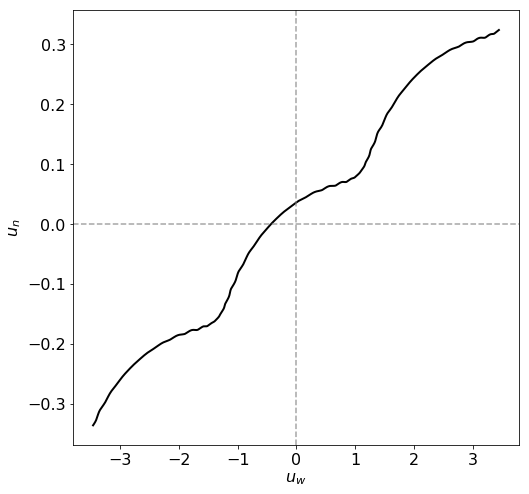

In [81]:
u_w, u_n = compute_u(t_, 0.01, t0, 1/tE*0.4, 0.1, 0.2)


fig, ax = plt.subplots(figsize=(8,8))
ax.plot(u_w, u_n, color='black', lw=2.)
ax.axvline(0., color='grey', linestyle='dashed', alpha=0.7)
ax.axhline(0., color='grey', linestyle='dashed', alpha=0.7)
# ax.grid()
ax.set_xlabel(r'$u_w$')
ax.set_ylabel('$u_n$')
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)

$\theta_E=\sqrt{\frac{4GM}{c^2}\left(\frac{1}{D_L}-\frac{1}{D_S}\right)}$